In [1]:
import os
os.environ['HTTP_PROXY'] = "http://127.0.0.1:10809"
os.environ['HTTPS_PROXY'] = "http://127.0.0.1:10809"

In [2]:
import geemap
import ee
Map=geemap.Map()
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [3]:
# 定义参数
region = 'prd'
year = '2020'
startDate = year + '-01-01'
endDate = year + '-12-31'

In [4]:
# # 大庆市
# roi = ee.Geometry.Rectangle([123.9355, 45.8362,125.3055, 46.8762])
# # 天津市
# roi = ee.Geometry.Rectangle([115.9244, 38.6272,117.4944,39.6372])
# # 武汉市
# roi = ee.Geometry.Rectangle([113.7393, 29.8642,115.0993, 30.9242])
# # 珠三角
roi = ee.Geometry.Rectangle([112.7614, 22.2347,114.0514, 23.2547])
# 青藏高原
# roi = ee.Geometry.Rectangle([89.8826, 34.6579,91.3626, 35.8279])
Map.addLayer(roi, {}, "roi")
Map.centerObject(roi,9)

In [5]:
## 指数的计算
def water_index(img):
    image = img
    ndvi=image.normalizedDifference(['B5', 'B4']).rename('NDVI')
    ndwi=image.normalizedDifference(['B3', 'B5']).rename("NDWI")
    mndwi=image.normalizedDifference(['B3', 'B6']).rename("mNDWI")
    ndvi_mndwi = ndvi.subtract(mndwi).rename('ndvi_mndwi')
    cwi=image.select('B3').divide(image.select('B6')).rename("CWI")
    awei = image.expression('(B2 + 2.5*B3 - 1.5*(B5+B6) - 0.25*B7)/10000',
        {
          'B2': image.select('B2'),
          'B3': image.select('B3'),    
          'B5': image.select('B5'),    
          'B6': image.select('B6'),
          'B7': image.select('B7'),
        }).rename('AWEI')
    ewi = image.expression('(B3 - B5 - B6)/(B3 + B5 + B6)',
        {
          'B3': image.select('B3'),    
          'B5': image.select('B5'),    
          'B6': image.select('B6'),
        }).rename('EWI')
    evi = image.expression('2.5*(B5 - B4)/(B5 + 6*B4 - 7.5*B2 + 1)',
        {
          'B2': image.select('B2'),
          'B4': image.select('B4'),
          'B5': image.select('B5'),    
        }).rename('EVI')
    return image.addBands(ndvi).addBands(ndwi).addBands(mndwi).addBands(cwi).addBands(awei).addBands(ewi).addBands(evi).addBands(ndvi_mndwi)

elevation = ee.Image("users/311605001111/hillshade_" + region)
def maskSR(img):
    cloudShadowBitMask = (1 << 3)
    cloudsBitMask = (1 << 5)
    snowBitMask = (1 << 4)   
    qa = img.select('pixel_qa')
    mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0) \
             .And(qa.bitwiseAnd(cloudsBitMask).eq(0)) \
             .And(qa.bitwiseAnd(snowBitMask).eq(0))
    azimuth = img.get('SOLAR_AZIMUTH_ANGLE')
    zenith = img.get('SOLAR_ZENITH_ANGLE')
    image = img.lt(0)
    bands = image.select('B2').add(image.select('B3')).add(image.select('B4')).add(image.select('B5')).add(image.select('B6')).add(image.select('B7'))
    outlier = bands.gt(0).remap([0,1],[1,0]).rename('outlier')
    return img.updateMask(mask).updateMask(outlier)
# img.updateMask(mask).updateMask(ee.Terrain.hillShadow(elevation,azimuth,zenith,200,True)).updateMask(outlier)
# 图像可视化参数
visParams = {'bands': ['B5', 'B6', 'B4'],'min': 0,'max': 3000,'gamma': 1.4}

In [6]:
# elevation = ee.Image("users/311605001111/hillshade_" + region)
# def maskSR(img):
#     cloudShadowBitMask = (1 << 3)
#     cloudsBitMask = (1 << 5)
#     snowBitMask = (1 << 4)   
#     qa = img.select('pixel_qa')
#     mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0) \
#                    .And(qa.bitwiseAnd(cloudsBitMask).eq(0)) \
#                    .And(qa.bitwiseAnd(snowBitMask).eq(0))
#     azimuth = img.get('SOLAR_AZIMUTH_ANGLE')
#     zenith = img.get('SOLAR_ZENITH_ANGLE')
#     image = img.lt(0)
#     bands = image.select('B2').add(image.select('B3')).add(image.select('B4')).add(image.select('B5')).add(image.select('B6')).add(image.select('B7'))
#     outlier = bands.gt(0).remap([0,1],[1,0]).rename('outlier')
#     return img.updateMask(mask).updateMask(outlier)

# # 图像可视化参数
# visParams = {'bands': ['B5', 'B6', 'B4'],'min': 0,'max': 3000,'gamma': 1.4}


# 数据集

In [7]:
l8 = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR').filterBounds(roi).filterDate('2020-01-01','2020-12-31').filter(ee.Filter.lt('CLOUD_COVER',10))
print(l8.aggregate_array('system:id').getInfo())

# l5 = ee.ImageCollection('LANDSAT/LE07/C01/T1_SR').filterBounds(roi).filterDate('2010-01-01','2010-12-31').filter(ee.Filter.lt('CLOUD_COVER',10))
# print(l5.aggregate_array('system:id').getInfo())

['LANDSAT/LC08/C01/T1_SR/LC08_121044_20200415', 'LANDSAT/LC08/C01/T1_SR/LC08_121044_20201227', 'LANDSAT/LC08/C01/T1_SR/LC08_121045_20201227', 'LANDSAT/LC08/C01/T1_SR/LC08_122044_20200218', 'LANDSAT/LC08/C01/T1_SR/LC08_122044_20201116', 'LANDSAT/LC08/C01/T1_SR/LC08_122045_20201202']


In [8]:
#  'LANDSAT/LC08/C01/T1_SR/LC08_122044_20150103', 
#  'LANDSAT/LC08/C01/T1_SR/LC08_122044_20150119', 
#  'LANDSAT/LC08/C01/T1_SR/LC08_122044_20151018',

#  LANDSAT/LC08/C01/T1_SR/LC08_122044_20200218
#  LANDSAT/LC08/C01/T1_SR/LC08_122044_20201116 
#  LANDSAT/LC08/C01/T1_SR/LC08_122044_20201202
#  LANDSAT/LC08/C01/T1_SR/LC08_122045_20201202


a = ee.Image('LANDSAT/LC08/C01/T1_SR/LC08_122044_20201202')
image = maskSR(water_index(a))
# image = water_index(a)
visParams = {'bands': ['B5', 'B4', 'B3'],'min': 0,'max': 3000,'gamma': 1.4}
Map.addLayer(image.clip(roi), visParams,'image')
Map

Map(bottom=57328.0, center=[22.74535995937371, 113.40640000000008], controls=(WidgetControl(options=['position…

In [ ]:
113.8831, 23.0456, 113.9514, 23.1024
113.3262, 22.7845, 113.4026, 22.8491

# k-mean聚类，RF训练

In [9]:
bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7','NDVI','NDWI','mNDWI','CWI','AWEI','EWI','EVI']
# cluster与waterclass的对比
def Compare(feature):
    cluster = ee.Number(feature.get('cluster'))
    waterclass = ee.Number(feature.get('waterclass'))
    ft = ee.Algorithms.If(cluster.eq(waterclass),feature.set({'eq':1}),feature.set({'eq':0}))
    return ft
# k-mean聚类
def k_mean(sampleSET):
    clusterer = ee.Clusterer.wekaKMeans(2).train(sampleSET,bands)
    result = sampleSET.cluster(clusterer)
    right = result.map(Compare).filter(ee.Filter.eq('eq',0))
    error = result.map(Compare).filter(ee.Filter.eq('eq',1))
    filtered_sample = ee.FeatureCollection(ee.Algorithms.If(right.size().gt(error.size()),right,error))
    return filtered_sample

In [10]:
region = 'prd'
sample_region = 'PRD'

In [11]:
totalSamples = ee.FeatureCollection('users/311605001111/SAMPLE_' + sample_region + '/' + region + '_kmean100_9920' + '_v2')
print(totalSamples.size().getInfo())
label = 'waterclass'
bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7','NDVI','NDWI','mNDWI','CWI','AWEI','EWI','EVI']
trainedClassifier = ee.Classifier.smileRandomForest(150).train(totalSamples,label,bands)
new_result = image.select(bands).classify(trainedClassifier).eq(1).rename('waterclass') 
Map.addLayer(new_result.clip(roi).selfMask(),{'palette':['blue']},"new_result") 

19533


In [ ]:
q = new_result.subtract(mndwi)
Map.addLayer(q.clip(roi),{'palette':['red','white','blue']},"q") 

In [ ]:
# 100
awei = image.select('AWEI').gt(0)
Map.addLayer(awei.clip(roi).selfMask(),{'palette':['#16d60a']},'awei')

ndwi = image.select('NDWI').gt(-0.09)
Map.addLayer(ndwi.clip(roi).selfMask(),{'palette':['#7960ff']},'ndwi')

mndwi = image.select('mNDWI').gt(0.09)
Map.addLayer(mndwi.clip(roi).selfMask(),{'palette':['green']},'mndwi')

# 制图

In [12]:
region = 'prd'
sample_region = 'PRD'

In [ ]:
## 河流
# 113.9514, 23.0456, 113.8831, 23.1024
# 113.4026, 22.7845, 113.3262, 22.8491

Text(0.5, 1.0, 'Raw image (20201202)')

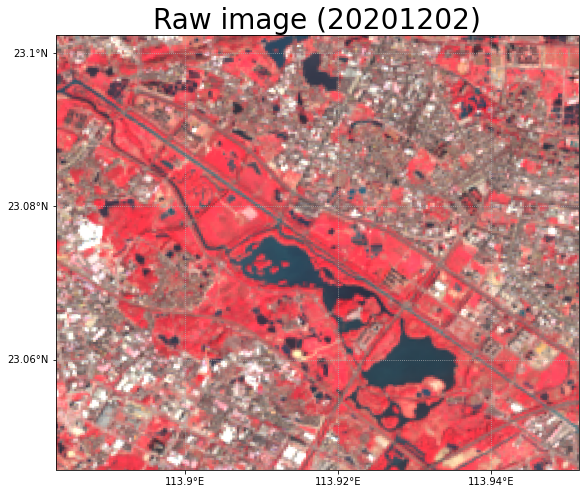

In [15]:
from matplotlib import pyplot as plt
import numpy as np
import matplotlib
from geemap import cartoee

re = [113.9514, 23.0456, 113.8831, 23.1024]
visParams = {'bands': ['B5', 'B4', 'B3'],'min': 0,'max': 3000,'gamma': 1.4}
# image = maskSR(water_index(ee.Image('LANDSAT/LC08/C01/T1_SR/LC08_122044_20201202'))).clip(roi)
image = water_index(ee.Image('LANDSAT/LC08/C01/T1_SR/LC08_122044_20201202')).clip(roi)

refer_img = image.visualize(**visParams)
fig = plt.figure(figsize=(12, 8))
ax = cartoee.get_map(refer_img, region=re)
cartoee.add_gridlines(ax, interval=[0.02,0.02], linestyle=":")
ax.set_title(label = 'Raw image (20201202)', fontsize=28)

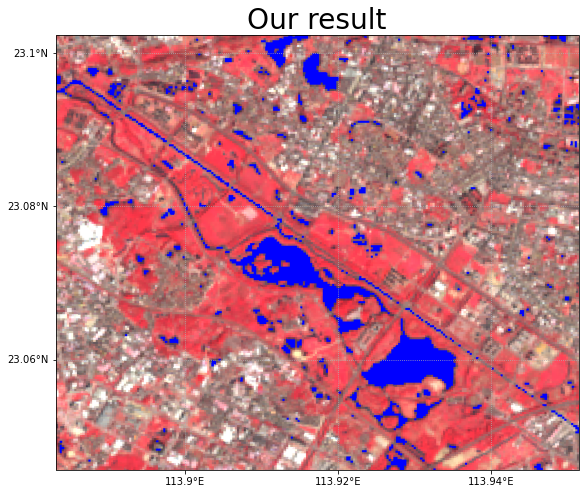

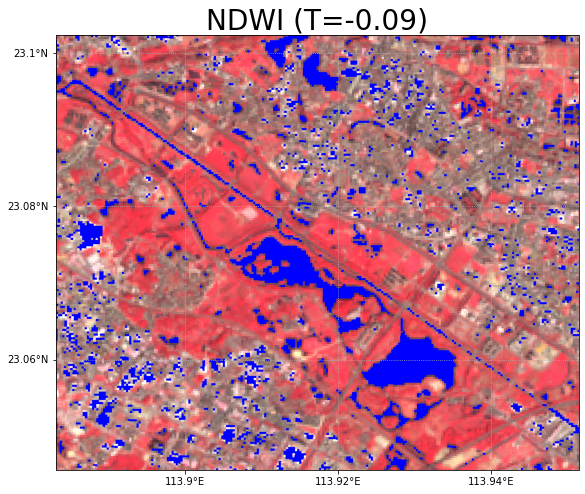

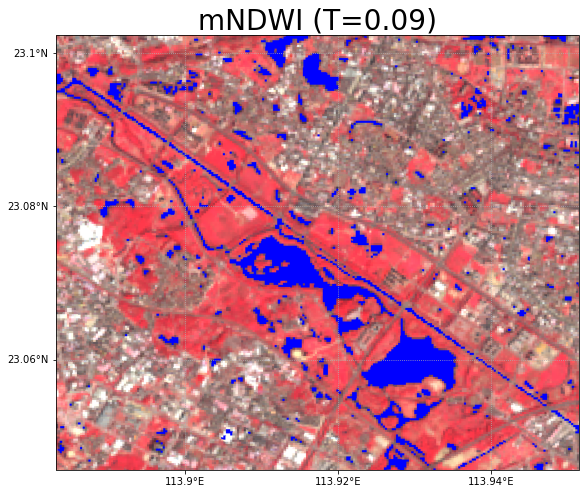

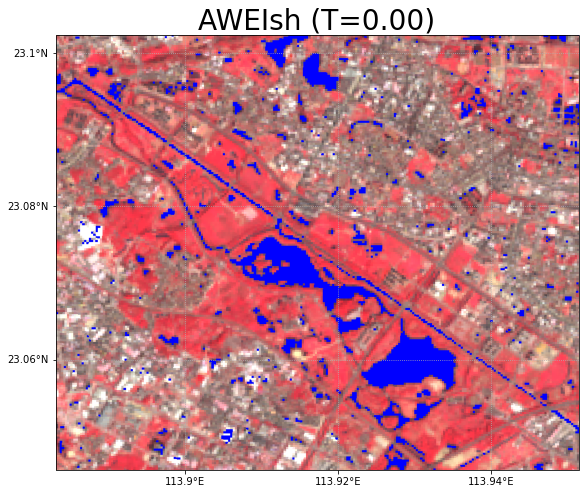

In [16]:
from matplotlib import pyplot as plt
import numpy as np
import matplotlib
from geemap import cartoee

item = [['new_result','Our result'],['ndwi','NDWI (T=-0.09)'],['mndwi','mNDWI (T=0.09)'],['awei','AWEIsh (T=0.00)']]

re = [113.9514, 23.0456, 113.8831, 23.1024]
visParams = {'bands': ['B5', 'B4', 'B3'],'min': 0,'max': 3000,'gamma': 1.4}
# image = maskSR(water_index(ee.Image('LANDSAT/LC08/C01/T1_SR/LC08_122044_20201202'))).clip(roi)
image = water_index(ee.Image('LANDSAT/LC08/C01/T1_SR/LC08_122044_20201202')).clip(roi)


for it in item:
    if it[0] == 'new_result':
        totalSamples = ee.FeatureCollection('users/311605001111/SAMPLE_' + sample_region + '/' + region + '_kmean100_9920' + '_v2')
        label = 'waterclass'
        bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7','NDVI','NDWI','mNDWI','CWI','AWEI','EWI','EVI']
        trainedClassifier = ee.Classifier.smileRandomForest(150).train(totalSamples,label,bands)
        classify_result = image.select(bands).classify(trainedClassifier).eq(1).rename('waterclass')  
    elif it[0] == 'ndwi':
        classify_result = image.select('NDWI').gt(-0.08618295518615487)
    elif it[0] == 'mndwi':
        classify_result = image.select('mNDWI').gt(0.08589522993236504)
    elif it[0] == 'awei':
        classify_result = image.select('AWEI').gt(0)
    refer_img = image.visualize(**visParams)
    pw = classify_result.selfMask().visualize(**{'palette':['blue']})
    blend = refer_img.blend(pw)
    fig = plt.figure(figsize=(12, 8))
    ax = cartoee.get_map(blend, region=re)
    cartoee.add_gridlines(ax, interval=[0.02,0.02], linestyle=":")
    ax.set_title(label = it[1], fontsize=28)